Beginning after the matrix multiplication lesson, which has decent notes, but should take notes in a completely new Jupyter Notebook for better organization and retention.


# Forward Pass

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#export
from exp.nb_01 import *

def get_data():
    import os
    import torchvision.datasets as datasets
    root = '../data'
    if not os.path.exists(root):
        os.mkdir(root)
    train_set = datasets.MNIST(root=root, train=True, download=True)
    test_set = datasets.MNIST(root=root, train=False, download=True)
    x_train, x_valid = train_set.train_data.split([50000, 10000])
    y_train, y_valid = train_set.train_labels.split([50000, 10000])
    return (x_train.view(50000, -1) / 256.0), y_train.float(), (x_valid.view(10000, -1))/ 256.0, y_valid.float()

# The geographic intuition for this is picturing x's around a horizontal line (mean), bring that mean down to 0,
# then scale x's by dividing them by the standard deviation
def normalize(x, mean, std): return (x-mean)/std

In [2]:
x_train, y_train, x_valid, y_valid = get_data()

/opt/anaconda3/envs/snowflakes/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/anaconda3/envs/snowflakes/lib/python3.8/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
!pip show torchvision

Name: torchvision
Version: 0.8.2
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /opt/anaconda3/envs/snowflakes/lib/python3.8/site-packages
Requires: numpy, torch, pillow
Required-by: fastai


## Normalization

- We want mean to be 0 and standard deviation to be 1 for easier convergence, so we normalize. 
- Notice how we use train_mean and train_std to normalize valid data as well - that's because we don't want validation dataset to be in a different scale

In [ ]:
# before normalization
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

In [7]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [9]:
# after normalization
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(3.9162e-08), tensor(1.))

In [19]:
def assert_is_near_zero(a, threshold=1e-3): assert a.abs() < threshold, f"{a} is not near zero"
assert_is_near_zero(train_mean)

## Get shapes

In [23]:
num_samples, image_size = x_train.shape 
num_classes = y_train.max() + 1 
nh = 50

n = num_samples
m = image_size
c = num_classes

n, m, c, nh

(50000, 784, tensor(10.), 50)

## Intialization

- Initialization is *extremely* important. In 2019, they wrote a paper "Fixup Initialization: Residual Learning Without Normalization" in which they trained a 10,000 layer neural net WITHOUT normalization just by initializing everything carefully.

### Xavier Initialization

- To perform Standard Xavier Initialization, you just divide input by the sqrt(num_input_units), which would give you a mean of 0, and standard deviation of 1 / sqrt(m)

In [82]:
def lin(x, w, b): return x@w + b

In [83]:
# Forward pass without Initialization
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)

t = lin(x_valid, w1, b1)
t.mean(), t.std() # terrible, you want ~ (0,1) (mean,std)

(tensor(-2.4185), tensor(29.1872))

In [84]:
# Forward pass with Standard Xavier Init
w1 = torch.randn(m, nh) * math.sqrt(1/m)
b1 = torch.zeros(nh)

t = lin(x_valid, w1, b1)
t.mean(), t.std() # good

(tensor(0.0294), tensor(0.9735))

In [85]:
assert_is_near_zero(w1.mean())
assert_is_near_zero(w1.std() - 1/math.sqrt(m))

### Vanishing Activation/Gradient Problem

- Remember after performing the matrix multiplication, you have to pass it through relu, but each time you do that, you cut all activation values that are below 0 to 0 and thereby reduces the standard deviation. If your network is very deep, your standard deviation will keep getting reduced (possibly down to 0)

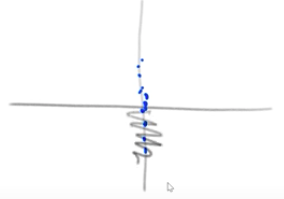

In [96]:
# clamp_min(n) means replace everything below n with n, in this case, relu means replacing everything negative with 0
# always try to use PyTorch function because they're generally implemented in C for you
def relu(x): return x.clamp_min(0.) 

t = relu(lin(x_valid, w1, b1)) 
t.mean(),t.std()

(tensor(0.5288), tensor(0.8368))

### Kaiming Initialization
- The problem with Xavier Initialization is that it doesn't combat the vanishing gradient problem very well. 
- Kaiming initialization is almost identical to Xavier initialization but with a 2 on top; it will keep the std around 

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

- This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets as well as Kaiming He initialization!) 

- So papers by competition winners are very good because they introduce MANY good ideas instead of just one tiny tweak.

In [91]:
# Forward pass with Kaiming Initialization
torch.manual_seed(42)
w1 = torch.randn(m, nh) * math.sqrt(2/m)
b1 = torch.zeros(nh)

t = relu(lin(x_valid, w1, b1))
t.mean(), t.std() 

(tensor(0.6624), tensor(0.9097))

In [92]:
# Forward pass with PyTorch's Kaiming Initialization, same thing
from torch.nn.init import kaiming_normal_

w1 = torch.empty(m, nh)
b1 = torch.zeros(nh)

torch.manual_seed(42)
kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std() 

(tensor(0.6624), tensor(0.9097))

- Note: Kaiming initialization is very good but notice the mean is still not zero - we have good reasons to want them to be. So we can define our own new_relu to see if it helps with normalizing the mean. It's an intuitive thing to do and papers are written from these minor tweaks. Maybe it'll help a lot in practice

In [95]:
def new_relu(x): return x.clamp_min(0.) - 0.5

In [100]:
# The new_relu seems to help!
torch.manual_seed(42)
w1 = torch.randn(m,nh) * math.sqrt(2./m)
t1 = new_relu(lin(x_valid, w1, b1))
t1.mean(), t1.std()

(tensor(0.1624), tensor(0.9097))

## Train a Model

In [136]:
torch.manual_seed(42)

w1 = torch.empty(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

def model(x):
    l1 = lin(x, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [137]:
%timeit -n 10 _=model(x_valid)

16.5 ms ± 722 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [138]:
assert model(x_valid).shape == torch.Size((x_valid.shape[0],1))

## Loss Function

- We wrongly use the MSE for now just for simplicity's sake

In [139]:
def mse(pred, trg): return ((pred - trg)**2).mean()

In [140]:
y_train, y_valid = y_train.float(), y_valid.float()

In [141]:
pred = model(x_train)

In [142]:
y_train.shape

torch.Size([50000])

In [143]:
pred.shape # not the exact shape, need to squeeze

torch.Size([50000, 1])

In [144]:
pred = pred.squeeze(-1)
pred.shape

torch.Size([50000])

In [145]:
mse(pred, y_train)

tensor(24.1021)

# Backward Pass

- During backward pass, you calculate the gradient of every w1, b1, w2, b2 with respect to the loss
- For each of the function below, we take the derivative of each layer in terms of loss, storing the result in thatlayer's .g -- in other words, x.grad stores the result of dloss/dx. Note x is the denominator, the layer.
- DON'T RUN THIS FUNCTION LOCALLY ON CPU. IT REQUIRES GPU!

In [147]:
def mse_grad(pred, loss):
    # gradient of loss with respect to the previous layer, so it's pred.grad == dloss/dpred
    pred.grad = (2. * (pred - loss)).mean()

In [148]:
def relu_grad(inp, out):
    # inp.grad == dout/dinp
    inp.grad = (inp > 0).float() * out.grad

In [ ]:
def lin_grad(inp, out, w, b):
    # dloss / dl
    inp.grad = out.grad @ w.t() 
    # dloss / dw
    w.grad = (inp.unsqueeze(-1) * out.grad.unsqueeze(1)).sum(0)
    # dloss / db
    b.grad = out.grad

In [152]:
torch.manual_seed(42)

w1 = torch.empty(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

def forward_and_backward(inp, target):
    # forward
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    pred = lin(l2, w2, b2)
    loss = mse(pred, y_train)    
    
    # backward
    # pred.grad = dloss/dpred
    mse_grad(pred, loss) 
    # l2.grad = dloss/dl2 = dloss/dpred * dpred/dl2
    # w2.grad = dloss/dw2 = dloss/dpred * dpred/dw2
    # b2.grad = dloss/db2 = dloss/dpred * dpred/db2
    lin_grad(l2, pred, w2, b2) 
    # l1.grad = dloss/dl1 = dloss/dl2 * dl2/dl1
    relu_grad(l1, l2)
    # x.grad = dloss/dx = dloss/dl1 * dl1/dx
    # w1.grad = dloss/dw1 = dloss/dl1 * dl1/dw1
    # b1.grad = dloss/db1 = dloss/dl1 * dl1/db1
    lin_grad(x, l1, w1, b1)

In [ ]:
# Perform a full pass and save gradients for testing against later
forward_and_backward(x_train, y_train)
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

# Checkpoint: https://course19.fast.ai/videos/?lesson=8 , 1:46:17